In [57]:
# Initialize GPU
import pyclesperanto_prototype as cle
import beetlesafari as bs
import numpy as np

cle.select_device('RTX')

<GeForce RTX 2070 on Platform: NVIDIA CUDA (2 refs)>

In [58]:
%gui qt

In [59]:
# convenience methods
def show(image, labels=False, title=None, use_napari=False):
    if len(image.shape) == 3:
        # print(image.shape)
        max_projection = cle.create([image.shape[1], image.shape[2]])
        cle.maximum_z_projection(image, max_projection)
        cle.imshow(cle.transpose_xy(max_projection), labels=labels, min_display_intensity=0)
    else:
        cle.imshow(cle.transpose_xy(image), labels=labels, min_display_intensity=0)    
    
    if use_napari:
        if labels:
            show.viewer.add_labels(cle.pull_zyx(image), name=title)
        else:
            show.viewer.add_image(cle.pull_zyx(image), name=title)

import napari

# create Qt GUI context
napari.gui_qt()        
show.viewer = napari.Viewer()

from napari_pyclesperanto_assistant import napari_plugin
napari_plugin(show.viewer)

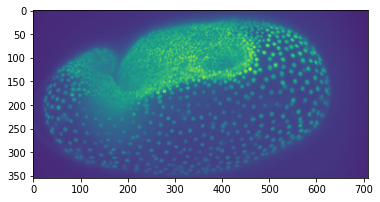

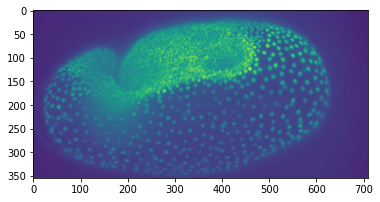

In [60]:
# Configure data source
path = 'C:/structure/data/2019-12-17-16-54-37-81-Lund_Tribolium_nGFP_TMR/stacks/C0opticsprefused/'
filename_1 = path + '001200.raw'
filename_2 = path + '001201.raw'
width = 512
height = 1024
depth = 71
voxel_size = [3, 0.6934, 0.6934]

# load and resample
def load_and_resample(filename, width, height, depth, voxel_size):
    img_arr = bs.imread_raw(filename, width, height, depth)
    buffer = cle.push_zyx(img_arr)
    return cle.resample(buffer, factor_x = voxel_size[2], factor_y = voxel_size[1], factor_z = voxel_size[0])

input_image = load_and_resample(filename_1, width, height, depth, voxel_size)
other_image = load_and_resample(filename_2, width, height, depth, voxel_size)
    
show(input_image, title="original", use_napari=True)
show(other_image, title="next timepoint", use_napari=True)

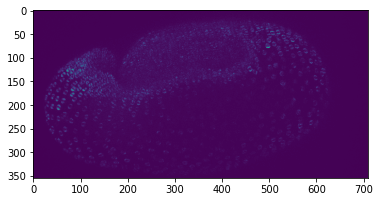

In [61]:
# determine local changes
difference_image = cle.squared_difference(input_image, other_image)
show(difference_image, title="difference between timepoints", use_napari=True)

# Segmentation

subtract background took 0.18154096603393555
Num spots: 1789.0
spot detection took 0.07673239707946777
corrected number of spots 1789.0
cell segmentation took 0.020345687866210938


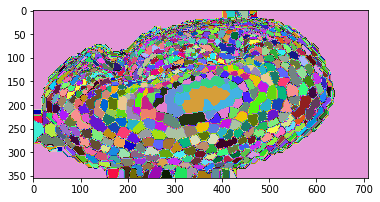

number of cells 1789.0
corrected number of cells 1784.0
next timepoint:
subtract background took 0.1843099594116211
Num spots: 1808.0
spot detection took 0.08535480499267578
corrected number of spots 1808.0
cell segmentation took 0.031522512435913086


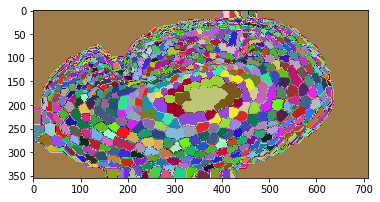

number of cells 1808.0
corrected number of cells 1804.0


In [62]:
def segmentation(image):
    background_subtracted = None
    background_subtracted = bs.background_subtraction(image, background_subtracted, 2, 7)
    # show(background_subtracted, title="background subtracted", use_napari=True)

    spots = cle.create_like(background_subtracted) 
    spots = bs.spot_detection(background_subtracted, spots, threshold=10)
    # show(spots, title="spots", use_napari=True)

    # temporary workaround; see https://github.com/clEsperanto/pyclesperanto_prototype/issues/63
    new_spots = cle.create_like(spots)
    cle.close_index_gaps_in_label_map(spots, new_spots)
    spots = new_spots
    print("corrected number of spots", cle.maximum_of_all_pixels(spots))

    cells = cle.create_like(spots)
    cells = bs.cell_segmentation(spots, cells, number_of_dilations=14, number_of_erosions=8)

    show(cells, title="cells", use_napari=True, labels=True)

    print("number of cells", cle.maximum_of_all_pixels(cells))

    # temporary workaround; see https://github.com/clEsperanto/pyclesperanto_prototype/issues/63
    new_cells = cle.create_like(cells)
    cle.close_index_gaps_in_label_map(cells, new_cells)
    cells = new_cells
    print("corrected number of cells", cle.maximum_of_all_pixels(cells))
    
    return cells

cells = segmentation(input_image)
print("=======================================\nnext timepoint:")
other_cells = segmentation(other_image)


# Quantiative analysis
## Neighbors and distances

(1785, 1785)


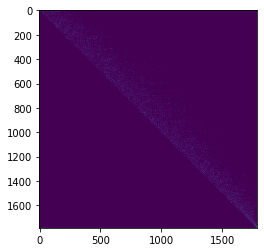

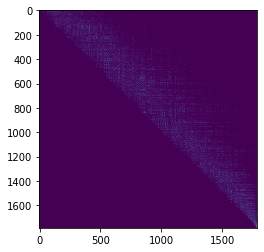

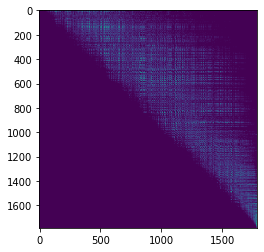

In [63]:
# determine neighbors of cells
touch_matrix = cle.generate_touch_matrix(cells)

# ignore touching the background
cle.set_column(touch_matrix,0,0)
cle.set_row(touch_matrix,0,0)

print(touch_matrix.shape)
show(touch_matrix)

# determine neighbors of neigbors
neighbors_of_neighbors = cle.neighbors_of_neighbors(touch_matrix)
show(neighbors_of_neighbors)

# determine neighbors of neighbors of neighbors
neighbors_of_neighbors_of_neighbors = cle.neighbors_of_neighbors(neighbors_of_neighbors)
show(neighbors_of_neighbors_of_neighbors)

pointlist (3, 1784)


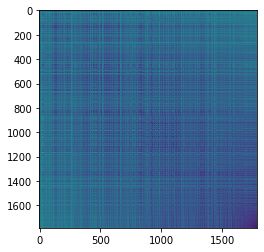

In [64]:
# determine distances of all cells to all cells
pointlist = cle.centroids_of_labels(cells)
print("pointlist", pointlist.shape)
distance_matrix = cle.generate_distance_matrix(pointlist, pointlist)
show(distance_matrix)

## Estimate displacement

other_pointlist (3, 1804)
displacement_matrix (1785, 1805)
displacement_vector (1, 1785)


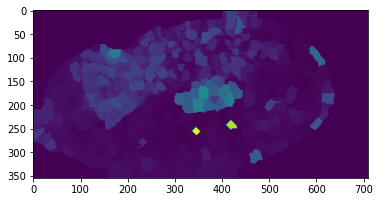

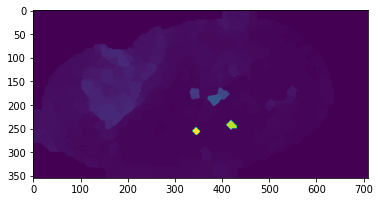

In [65]:
# determine closest distances over time; a simple displacement estimation
other_pointlist = cle.centroids_of_labels(other_cells)
print("other_pointlist", other_pointlist.shape)
displacement_matrix = cle.generate_distance_matrix(pointlist, other_pointlist)
print("displacement_matrix", displacement_matrix.shape)

displacement_vector = cle.average_distance_of_n_closest_points(displacement_matrix)
print("displacement_vector", displacement_vector.shape)

displacement_map = cle.replace_intensities(cells, displacement_vector)
show(displacement_map, title="distance map", use_napari=True)

displacement_map = cle.replace_intensities(cells, cle.median_of_touching_neighbors(displacement_vector,neighbors_of_neighbors))
show(displacement_map, title="local median distance map", use_napari=True)

## Measure average neigbor distance

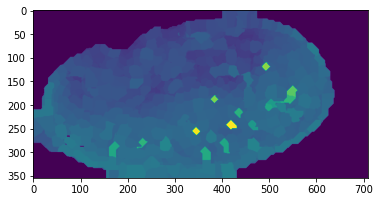

In [66]:
nearest_neighbor_distance = cle.average_distance_of_n_closest_points(distance_matrix, n=6)

nn_distance_map = cle.replace_intensities(cells, nearest_neighbor_distance)
show(nn_distance_map, title="distance map", use_napari=True)

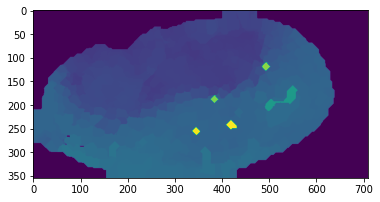

In [67]:
local_nearest_neighbor_distance = cle.median_of_touching_neighbors(nearest_neighbor_distance, neighbors_of_neighbors)

nn_distance_map = cle.replace_intensities(cells, local_nearest_neighbor_distance)
show(nn_distance_map, title="local median distance map", use_napari=True)

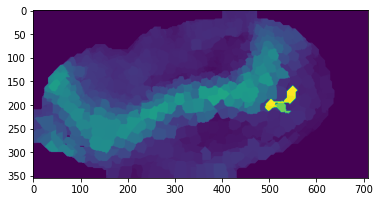

In [68]:
local_stddev_nearest_neighbor_distance = cle.standard_deviation_of_touching_neighbors(local_nearest_neighbor_distance, neighbors_of_neighbors)

nn_distance_map = cle.replace_intensities(cells, local_stddev_nearest_neighbor_distance)
show(nn_distance_map, title="local stddev average distance map", use_napari=True)

## Measure neighbor count

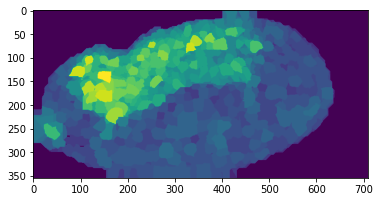

In [69]:
touching_neighbor_count = cle.count_touching_neighbors(touch_matrix)
cle.set_column(touching_neighbor_count, 0, 0)

tnc_map = cle.replace_intensities(cells, touching_neighbor_count)
show(tnc_map, title="neighbor count", use_napari=True)

[[0. 9. 8. ... 7. 6. 7.]]


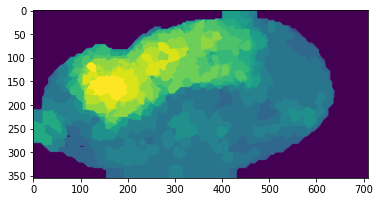

In [70]:
local_touching_neighbor_count = cle.median_of_touching_neighbors(touching_neighbor_count, touch_matrix)

print(local_touching_neighbor_count)
tnc_map = cle.replace_intensities(cells, local_touching_neighbor_count)
show(tnc_map, title="local median neighbor count", use_napari=True)

## Measure size

In [71]:
print(cle.maximum_of_all_pixels(cells))
regionprops = cle.statistics_of_background_and_labelled_pixels(input_image, cells)
print(len(regionprops))

1784.0
1785


[[   0. 3578. 3089. ... 8486. 7314. 7980.]]


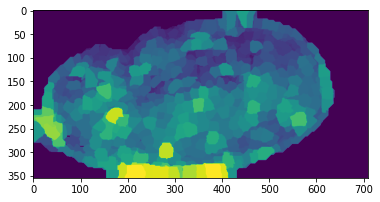

In [72]:
size = cle.push_zyx(np.asarray([[r.area for r in regionprops]]))

# ignore background
cle.set_column(size, 0, 0)

print(size)
size_map = cle.replace_intensities(cells, size)
show(size_map, title="size", use_napari=True)

## Measure mean intensity

[[  0.      520.4715  188.0861  ... 267.60345 234.75485 248.0163 ]]


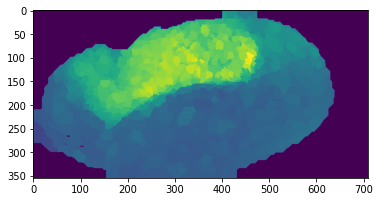

In [73]:
intensity = cle.push_zyx(np.asarray([[r.mean_intensity for r in regionprops]]))

# ignore background
cle.set_column(intensity, 0, 0)

print(intensity)
intensity_map = cle.replace_intensities(cells, intensity)
show(intensity_map, title="intensity", use_napari=True)

## Measure standard_deviation intensity

[[  0.      520.4715  188.0861  ... 267.60345 234.75485 248.0163 ]]


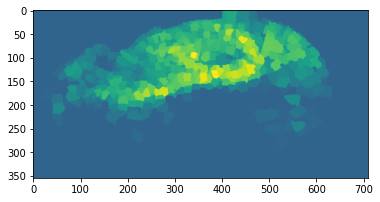

In [74]:
standard_deviation_intensity = cle.push_zyx(np.asarray([[r.standard_deviation_intensity for r in regionprops]]))

# ignore background
cle.set_column(intensity, 0, 0)

print(intensity)
intensity_map = cle.replace_intensities(cells, standard_deviation_intensity)
show(intensity_map, title="intensity", use_napari=True)

## Measure major_axis_length

[[ 0.       34.69095  34.5447   ... 38.01982  35.621105 36.602993]]


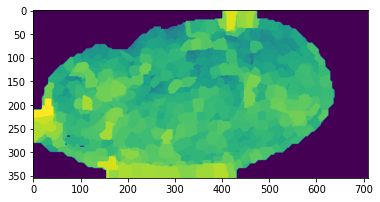

In [75]:
major_axis_length = cle.push_zyx(np.asarray([[r.major_axis_length for r in regionprops]]))

# ignore background
cle.set_column(major_axis_length, 0, 0)

print(major_axis_length)
major_axis_length_map = cle.replace_intensities(cells, major_axis_length)
show(major_axis_length_map, title="major_axis", use_napari=True)

[[ 0.       21.253113 19.250889 ... 31.84853  29.42747  31.131058]]


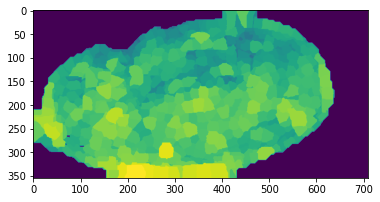

In [76]:
minor_axis_length = cle.push_zyx(np.asarray([[r.minor_axis_length for r in regionprops]]))

# ignore background
cle.set_column(minor_axis_length, 0, 0)

print(minor_axis_length)
minor_axis_length_map = cle.replace_intensities(cells, minor_axis_length)
show(minor_axis_length_map, title="minor_axis", use_napari=True)

# Plotting

In [77]:
print(nearest_neighbor_distance.shape)
print(touching_neighbor_count.shape)
print(local_stddev_nearest_neighbor_distance.shape)
print(intensity.shape)


(1, 1785)
(1, 1785)
(1, 1785)
(1, 1785)


## Ploting the raw measurements

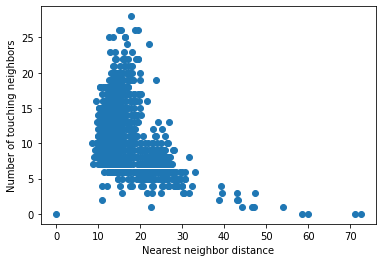

In [78]:
import matplotlib.pyplot as plt

plt.scatter(nearest_neighbor_distance, touching_neighbor_count)
plt.xlabel("Nearest neighbor distance")
plt.ylabel("Number of touching neighbors")
plt.show()

## Plotting the locally averaged measurements

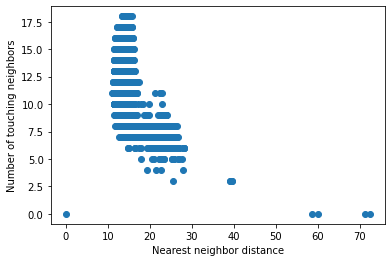

In [79]:
import matplotlib.pyplot as plt

plt.scatter(local_nearest_neighbor_distance, local_touching_neighbor_count)
plt.xlabel("Nearest neighbor distance")
plt.ylabel("Number of touching neighbors")
plt.show()

# Clustering

In [90]:
num_classes = 5

raw_data = [
    size,
    intensity,
    standard_deviation_intensity,
    major_axis_length,
    minor_axis_length,
    touching_neighbor_count,
    displacement_vector,
    cle.average_distance_of_n_closest_points(distance_matrix, n=1),
    cle.average_distance_of_n_closest_points(distance_matrix, n=2),
    cle.average_distance_of_n_closest_points(distance_matrix, n=3),
    cle.average_distance_of_n_closest_points(distance_matrix, n=4),
    cle.average_distance_of_n_closest_points(distance_matrix, n=5),
    cle.average_distance_of_n_closest_points(distance_matrix, n=6),
    cle.average_distance_of_n_closest_points(distance_matrix, n=10),
    cle.average_distance_of_n_closest_points(distance_matrix, n=15),
    cle.average_distance_of_n_closest_points(distance_matrix, n=20),
]

neighborhoods = [touch_matrix, neighbors_of_neighbors, neighbors_of_neighbors_of_neighbors]

preproc_data = []

for element in raw_data:
    #print(element[0].size)
    preproc_data.append(element[0])
    
    for neighborhood in neighborhoods:
    
        median = cle.median_of_touching_neighbors(element, neighborhood)
        preproc_data.append(median[0])
    
        stddev = cle.standard_deviation_of_touching_neighbors(element, neighborhood)
        preproc_data.append(stddev[0])
    
        mean = cle.mean_of_touching_neighbors(element, neighborhood)
        preproc_data.append(mean[0])
    
        minimum = cle.minimum_of_touching_neighbors(element, neighborhood)
        preproc_data.append(minimum[0])

        maximum = cle.maximum_of_touching_neighbors(element, neighborhood)
        preproc_data.append(maximum[0])

data = np.asarray(preproc_data).T
print(data.shape)

(1785, 256)


In [91]:
def show_prediction(cells, prediction, name = "", use_napari=True):
    predicition_vector = cle.push_zyx(np.asarray([prediction]) + 1)

    # set background to 0
    cle.set_column(predicition_vector, 0, 0)
    print(predicition_vector)

    print(prediction)
    print(np.max(prediction))

    prediction_map = cle.replace_intensities(cells, predicition_vector)
    show(prediction_map, title="prediction " + name, use_napari=use_napari)
    
    mode_prediction = cle.mode_of_touching_neighbors(predicition_vector, neighbors_of_neighbors)
    prediction_map = cle.replace_intensities(cells, mode_prediction)
    show(prediction_map, title="prediction" + name, use_napari=use_napari)

## Gaussian mixture model

In [92]:
from sklearn import mixture

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=num_classes, covariance_type='full')
clf.fit(data)
# print(clf.means_, clf.covariances_)

GaussianMixture(n_components=5)

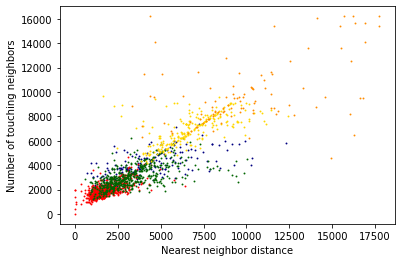

[[0. 3. 1. ... 4. 4. 4.]]
[1 2 0 ... 3 3 3]
4


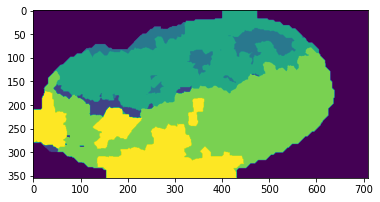

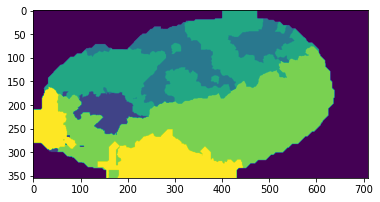

In [93]:
# inspired by https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html#sphx-glr-auto-examples-mixture-plot-gmm-py
color_iter = ['navy', 'red', 'darkgreen', 'gold', 'darkorange']

gmm_prediction = clf.predict(data)

for i in range(clf.n_components):
    #splot = plt.subplot(2, 1, 1 + index)
    color = color_iter[i]
    plt.scatter(data[gmm_prediction == i, 0], data[gmm_prediction == i, 1], .8, color=color)

plt.xlabel("Nearest neighbor distance")
plt.ylabel("Number of touching neighbors")
plt.show()

show_prediction(cells, gmm_prediction, "Gaussian Mixture")

## K-means clustering

[0 3 2 ... 4 4 4]
[[0. 4. 3. ... 5. 5. 5.]]
[0 3 2 ... 4 4 4]
4


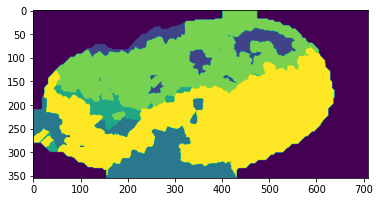

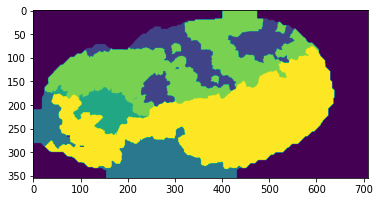

In [94]:
# inspired by https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=num_classes, random_state=0).fit(data)

kmeans_prediction = kmeans.predict(data)

print(kmeans_prediction)

show_prediction(cells, kmeans_prediction, "K-means clustering")

## MeanShift
https://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html#sphx-glr-auto-examples-cluster-plot-mean-shift-py

[[0. 1. 2. ... 2. 2. 2.]]
[0 0 1 ... 1 1 1]
1


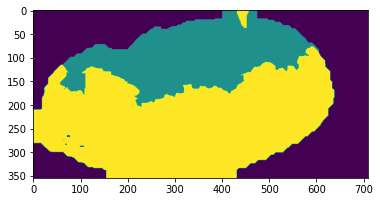

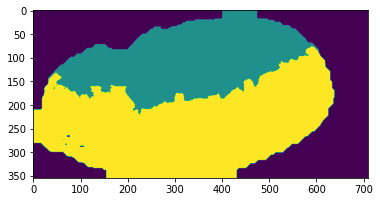

In [95]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(data, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(data)
ms_prediction = ms.labels_

show_prediction(cells, ms_prediction, "MeanShift")

## AffinityPropagation
https://scikit-learn.org/stable/auto_examples/cluster/plot_affinity_propagation.html#sphx-glr-auto-examples-cluster-plot-affinity-propagation-py

c:\users\rober\miniconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


[[ 0. 25. 13. ... 73. 73. 58.]]
[15 24 12 ... 72 72 57]
73


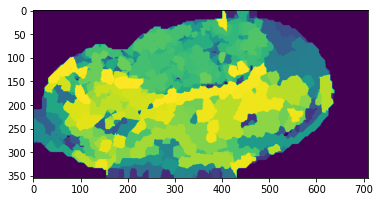

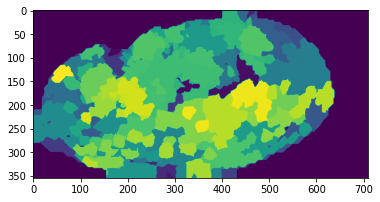

In [96]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation().fit(data)

ap_prediction = ap.labels_

show_prediction(cells, ap_prediction, "AffinityPropagation")

## SpectralClustering

c:\users\rober\miniconda3\lib\site-packages\sklearn\utils\validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)
c:\users\rober\miniconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


[[0. 3. 1. ... 3. 2. 2.]]
[0 2 0 ... 2 1 1]
2


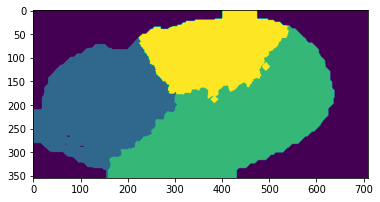

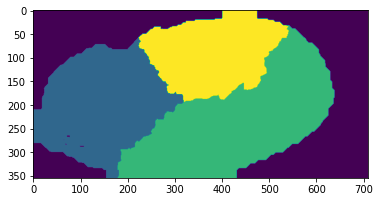

In [97]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(3, affinity='precomputed', n_init=100,
                         assign_labels='discretize')
sc_prediction = sc.fit_predict(cle.pull_zyx(touch_matrix))

show_prediction(cells, sc_prediction, "SpectralClustering")